In [1]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import xgboost as xgb
import utils 
import warnings
from sklearn.model_selection import train_test_split
warnings.filterwarnings(action='ignore', category=UserWarning)

c:\Users\franc\miniconda3\envs\tesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Se leen los datos y se seleccionan las variables que presentan una diferencia
# entre los individuos que presentan estres y los que no
data_path = Path(os.getcwd()).parent / "data"
silver_path = data_path / "silver" / "dreaddit_clean.csv"
df = pd.read_csv(silver_path, usecols= ["text","clean_text","clean_text_sentence_sep",
                                        "singular_pronouns", "avg_word_len",'lex_diversity',"label"])

In [3]:
#Configuracion de visualizaciones 

# Configurar el estilo de fondo con una cuadrícula
sns.set_style("whitegrid")

# Establecer una paleta de colores profesional
sns.set_palette("pastel")

# Configurar la tipografía y el tamaño de la fuente
sns.set_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", "font.sans-serif": ["Helvetica", "Arial"]})

# Desactivar spines innecesarios
sns.despine(trim=True, left=True);

<Figure size 640x480 with 0 Axes>

Text(0, 0.5, 'Registros')

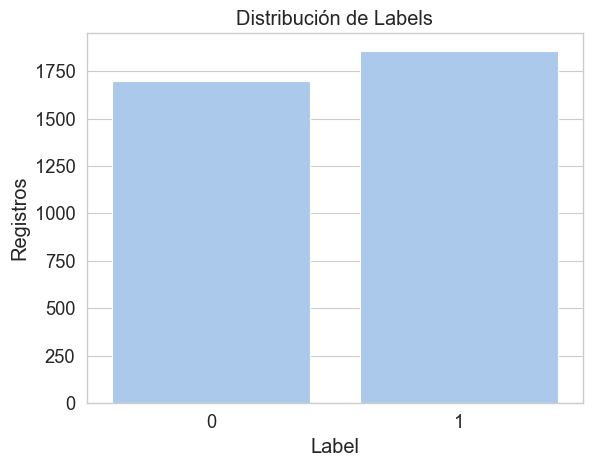

In [4]:
#distribucion de categorias en el label
label_dis = df.label.value_counts().reset_index()

g = sns.barplot(x="label", y="count", data=label_dis)
g.set_title("Distribución de Labels")
g.set_xlabel("Label")
g.set_ylabel("Registros")


In [5]:
features =['singular_pronouns', 'avg_word_len', 'lex_diversity']
X = df.loc[:,features]
y = df.label
feature_corr = X.corr()

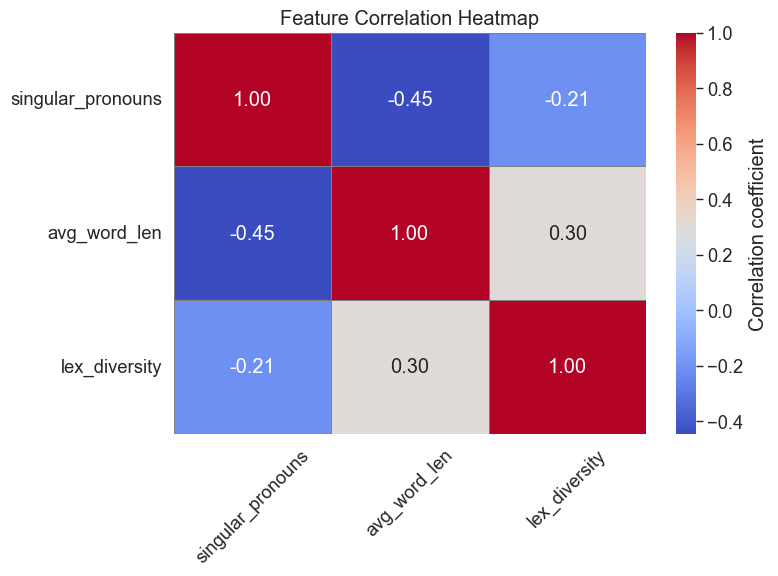

In [6]:
# Create the heatmap
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
sns.heatmap(feature_corr, annot=True, fmt=".2f", cmap='coolwarm',
            cbar_kws={'label': 'Correlation coefficient'}, linewidths=.5, linecolor='gray')

plt.title('Feature Correlation Heatmap')  # Add a title to the heatmap
plt.xticks(rotation=45)  # Rotate feature names for better visibility
plt.yticks(rotation=0)  # Ensure y-axis labels are horizontal for readability
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()

#### **Entrenamiento y evaluacion de modelos**

In [7]:
# Get and evaluate models
models = utils.get_models()
results, names = [], []
for name, model in models.items():
    scores = utils.evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print(f'>{name}: Mean F1 score = {scores.mean():.2f} with Std = {scores.std():.2f}')

>Logistic Regression: Mean F1 score = 0.69 with Std = 0.01
>K-Nearest Neighbors: Mean F1 score = 0.64 with Std = 0.01
>Decision Tree: Mean F1 score = 0.72 with Std = 0.01
>SVM: Mean F1 score = 0.71 with Std = 0.01
>Naive Bayes: Mean F1 score = 0.70 with Std = 0.01
>XGBoost: Mean F1 score = 0.71 with Std = 0.02
>Gradient Boosting: Mean F1 score = 0.71 with Std = 0.02
>Random Forest: Mean F1 score = 0.61 with Std = 0.02
>AdaBoost: Mean F1 score = 0.71 with Std = 0.01


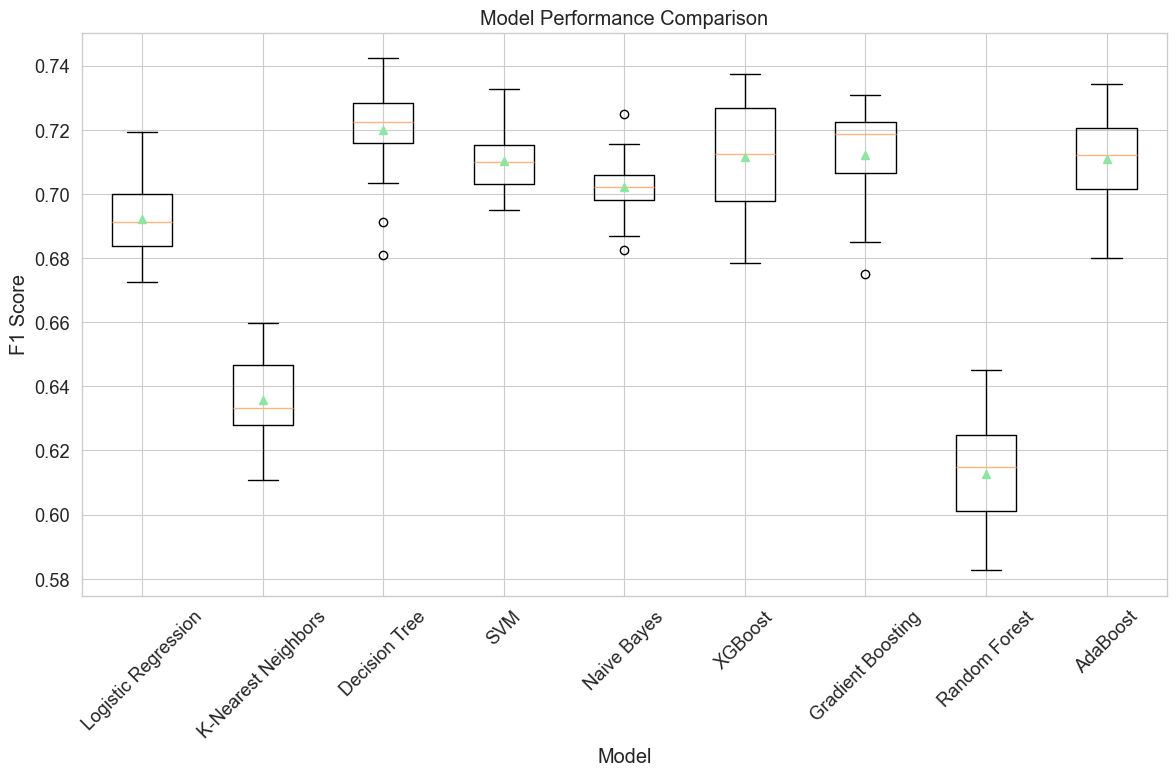

In [8]:
# Plotting model performance for comparison using boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


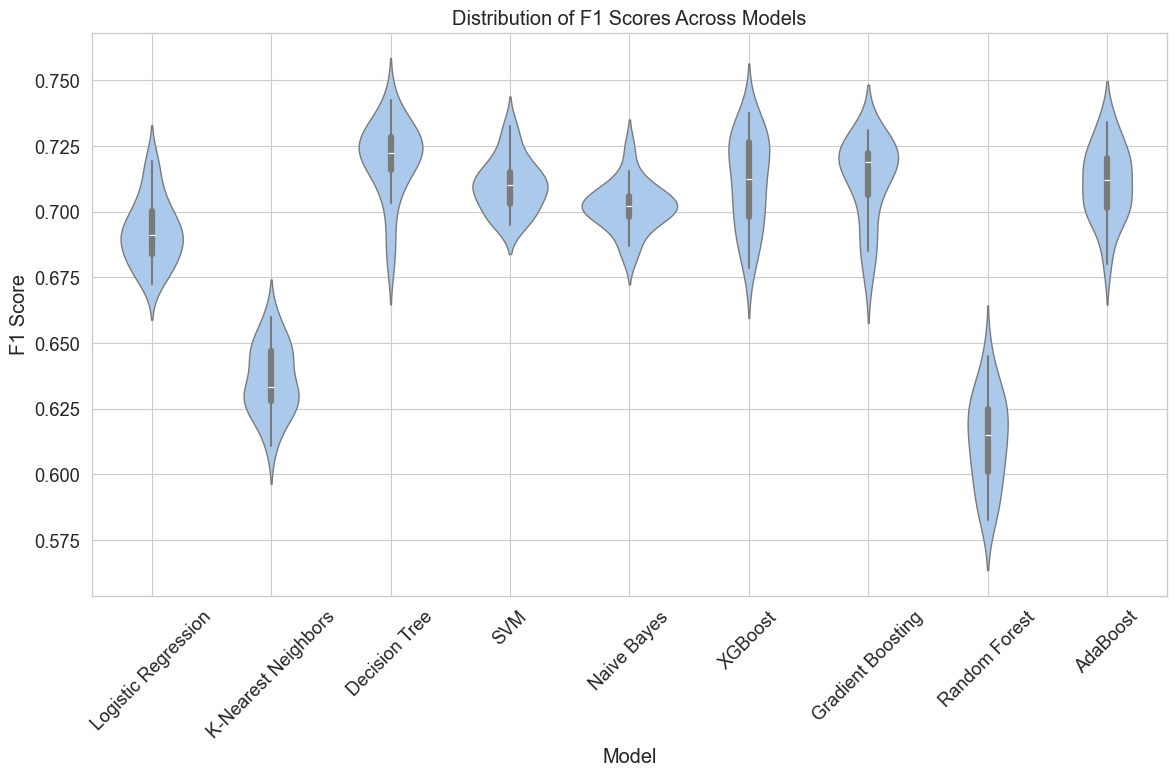

In [9]:
# Create a DataFrame for plotting
data = pd.DataFrame(data={name: scores for name, scores in zip(names, results)})
# Melt the DataFrame for easier plotting with seaborn
data_melted = data.melt(var_name='Model', value_name='F1 Score')

# Create the violin plot
plt.figure(figsize=(12, 8))  # Optional: Adjust the figure size as needed
sns.violinplot(x='Model', y='F1 Score', data=data_melted)
plt.title('Distribution of F1 Scores Across Models')  # Add a title to the plot
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.xlabel('Model')  # Label for the x-axis
plt.ylabel('F1 Score')  # Label for the y-axis
plt.grid(True)  # Optional: Add a grid for better readability
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()

#### **Importancia de features**

In [10]:
#Se separan los datos y se entrena un modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = xgb.XGBClassifier().fit(X_train, y_train)

In [11]:
# Crear el objeto Explainer
explainer = shap.Explainer(model, X_train)
# Calcular SHAP values
shap_values = explainer(X_test)

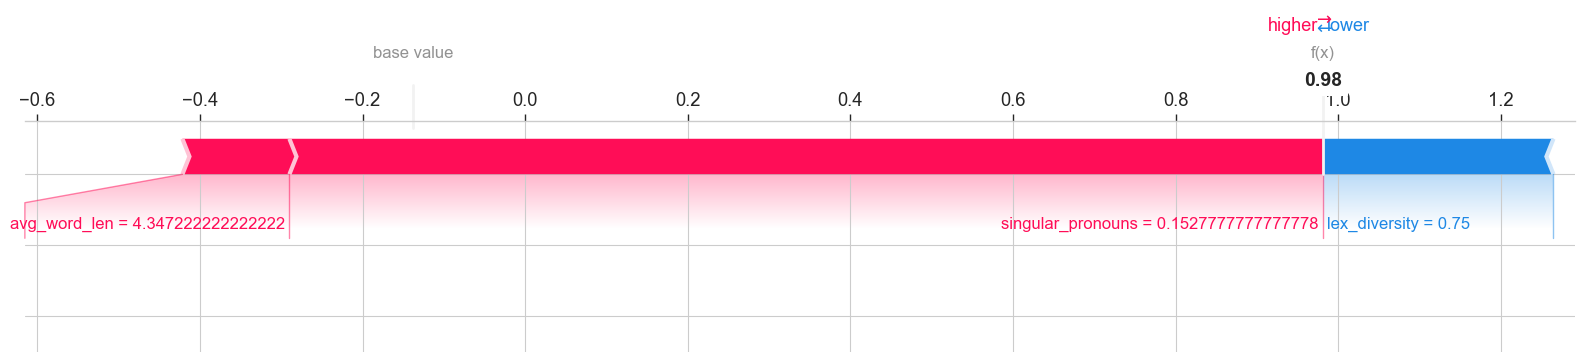

In [12]:
# Visualizar el primer prediccion
shap.plots.force(shap_values[10], matplotlib=True)

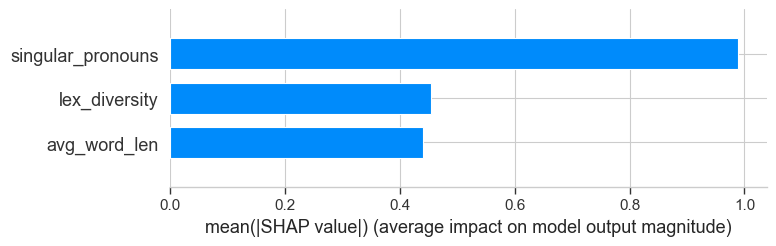

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar")


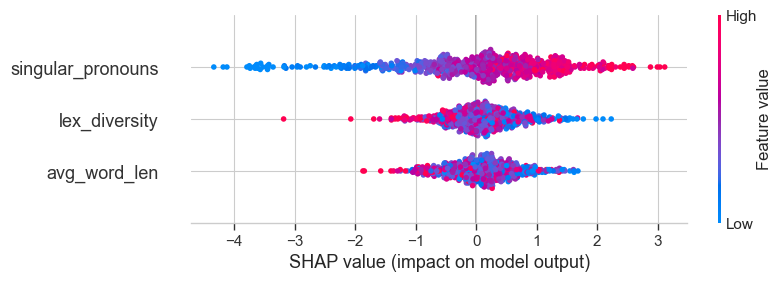

In [14]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

In [15]:
#shap.initjs()
#shap.force_plot(shap_values[:1000])